In [1]:
# This cell imports all the necessary python packages needed for analyzing the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix
import statsmodels.formula.api as smf
import statsmodels.stats.multitest as smt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the preprocessed data
data = pd.read_csv("data/data_for_analysis.csv")

In [3]:
# rename column names
data = data.rename(columns={
    'Dynamism Original Formula': "Dynamism", 
    'private_school': "public_private_indicator", 
    'undergraduate_school': 'undergrad_study_indicator', 
    'graduate_school': 'graduate_study_indicator', 
    'ivy': 'Ivy', 
    'cave_canem': 'cave_canem_indicator',
})

## Deal with missing data and categories
- when hbcu is missing, fill it with 0, since 0 is mode of hbcu
- when venue_type is N/A, assign it as "others" category
- when venue_type is Slam, assign it as "others" category. The reason is there are very few datapoints with Slam venue_type.

In [4]:
data[["hbcu"]] = data[["hbcu"]].replace({0: False, 1: True})
data[['hbcu']] = data[['hbcu']].fillna(0)
data[['venue_type']] = data[['venue_type']].fillna('Others')
data[["venue_type"]] = data[["venue_type"]].replace({'Slam': 'Others'})

## Take the absolute values of "IntensityMeanAbsVelocity" according to our discussions

In [5]:
data['IntensityMeanAbsVelocity'] = np.abs(data['IntensityMeanAbsVelocity'])

# Box plots

In [6]:
####################
# Boxplot and test #
####################
def boxplot(measure_name_vet, data_frame, figsize):
    for measure_name in measure_name_vet:
        response_column = data_frame[measure_name]
        column_name_vet = ["undergrad_study_indicator", "spoken_word", 'venue_type', 'hbcu', "graduate_study_indicator",
                           "cave_canem_indicator", "public_private_indicator", "region", "Ivy"]
        label_vet=["Undergraduate", 'spoken word', 'venue_type', 'hbcu', "Graduate", "Cave Canem", "Public or Private", "Region", "Ivy"]
        categorical_data_frame = data_frame[column_name_vet]

        fig, ax = plt.subplots(3, 3, figsize=figsize)
        for i, sub_ax in enumerate(ax.reshape(-1)):
            category_vet = np.unique(categorical_data_frame.iloc[:, i])
            response_vet = [response_column[categorical_data_frame.iloc[:, i] == category] for category in
                            category_vet]
            if column_name_vet[i] == "region":
                region_name_vet = ['Caribbean', 'Midwest', 'NYC', 'Northeast', 'South', 'West', 'Other']
                region_response_vet = []
                for region in region_name_vet:
                    region_response_vet.append(response_vet[np.where(category_vet == region)[0][0]])

                sub_ax.boxplot(region_response_vet, labels=region_name_vet)
                sub_ax.set_title(label_vet[i])
            elif column_name_vet[i] == 'venue_type':
                region_name_vet = ['SR', 'Studio', 'participatory setting', 'public reading space', 'self-recorded', 'Others']
                region_response_vet = []
                for region in region_name_vet:
                    # print(category_vet, region, np.where(category_vet == region))
                    region_response_vet.append(response_vet[np.where(category_vet == region)[0][0]])
                sub_ax.boxplot(region_response_vet, labels=region_name_vet)
                sub_ax.set_title(label_vet[i])
            else:
                sub_ax.boxplot(response_vet, labels=category_vet)
                sub_ax.set_xticklabels(["No", "Yes"])
                sub_ax.set_title(label_vet[i])
        plt.tight_layout()

        fig.suptitle(measure_name, y = 1.02, fontweight ="bold")
        plt.savefig('data/boxplots_' + measure_name + '.pdf')
        plt.show()

## Box plots of "f0Mean"

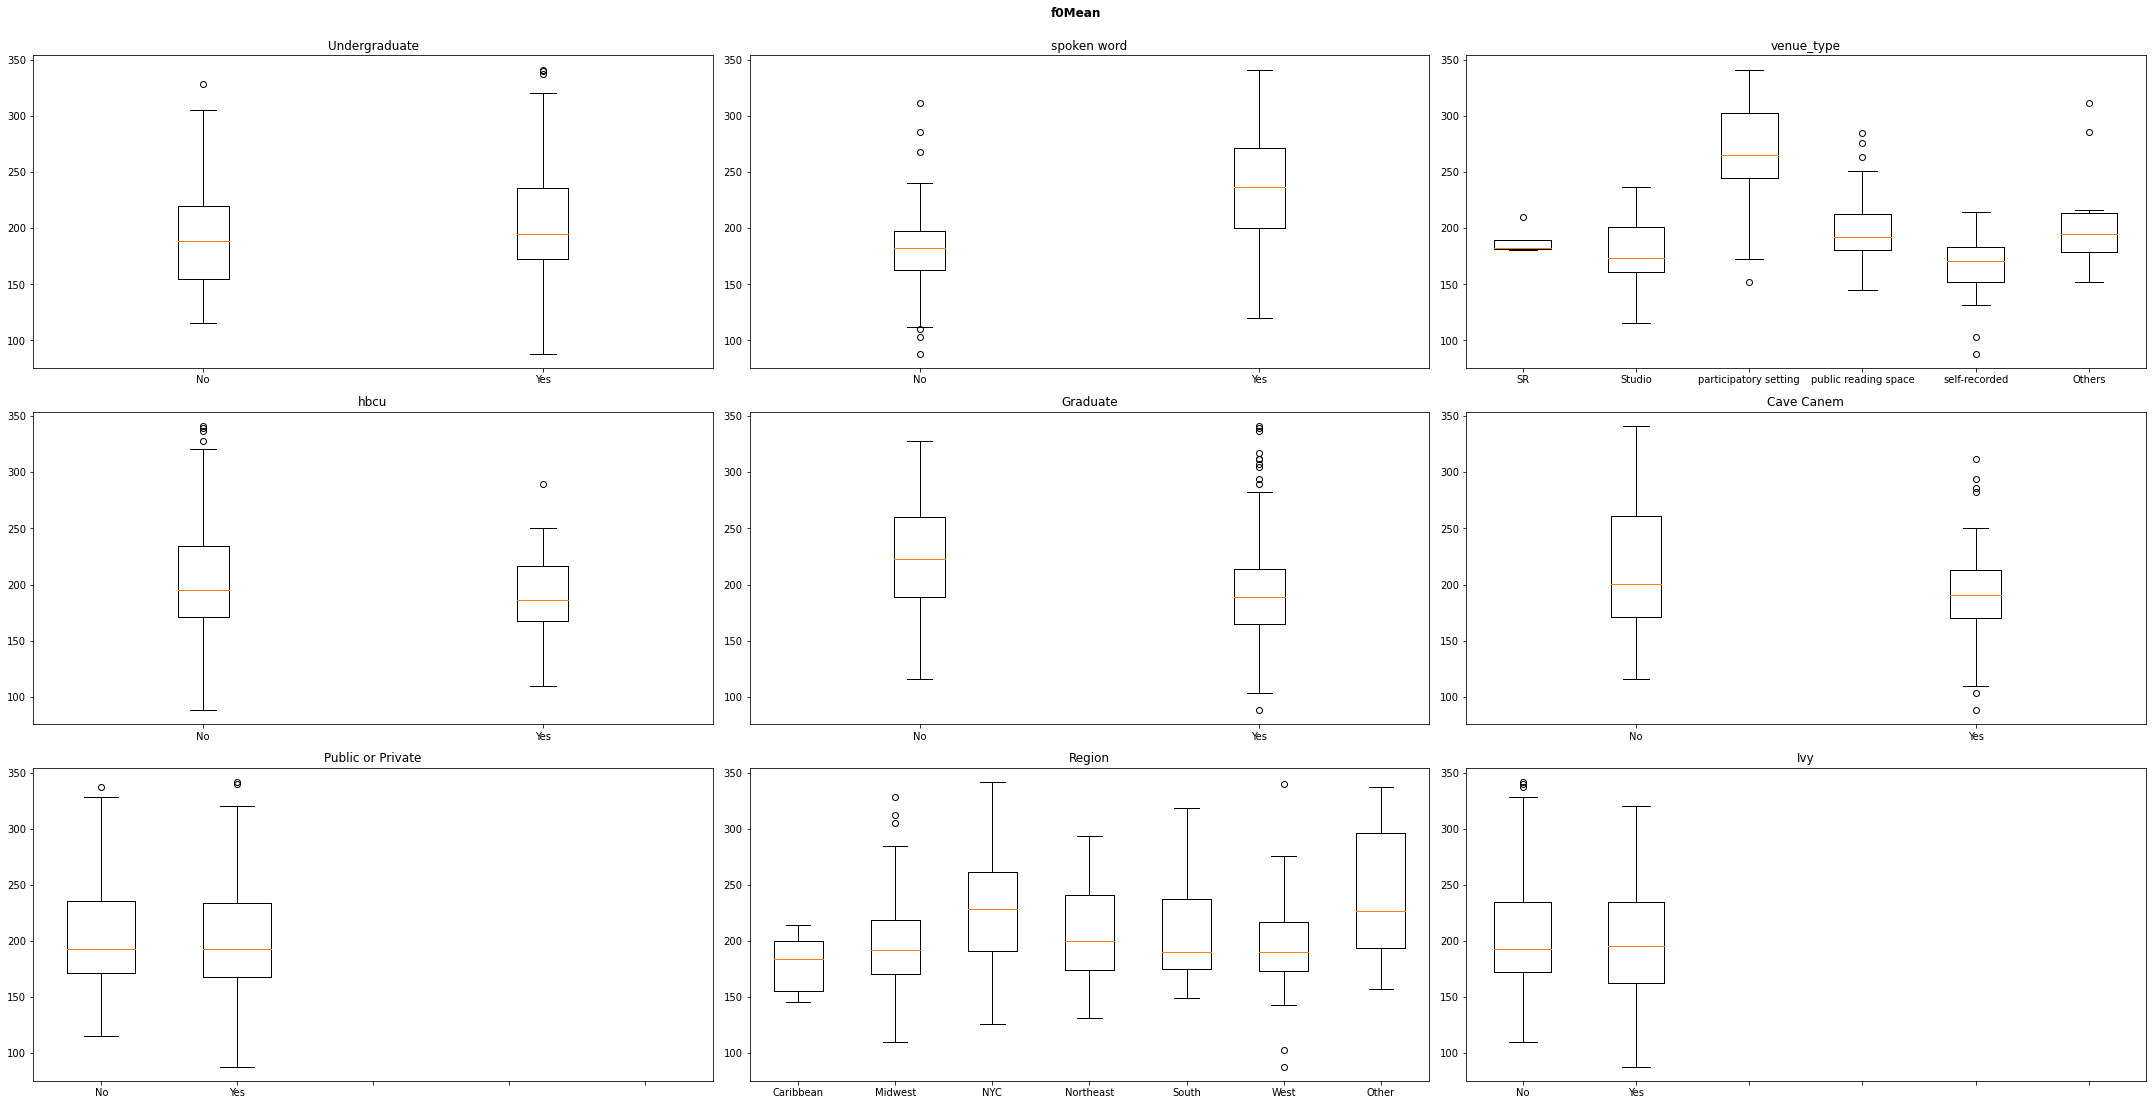

In [7]:
_ = boxplot(measure_name_vet=['f0Mean'], data_frame=data, figsize=(30,15))

## Box plots of "f0MeanAbsVelocity"

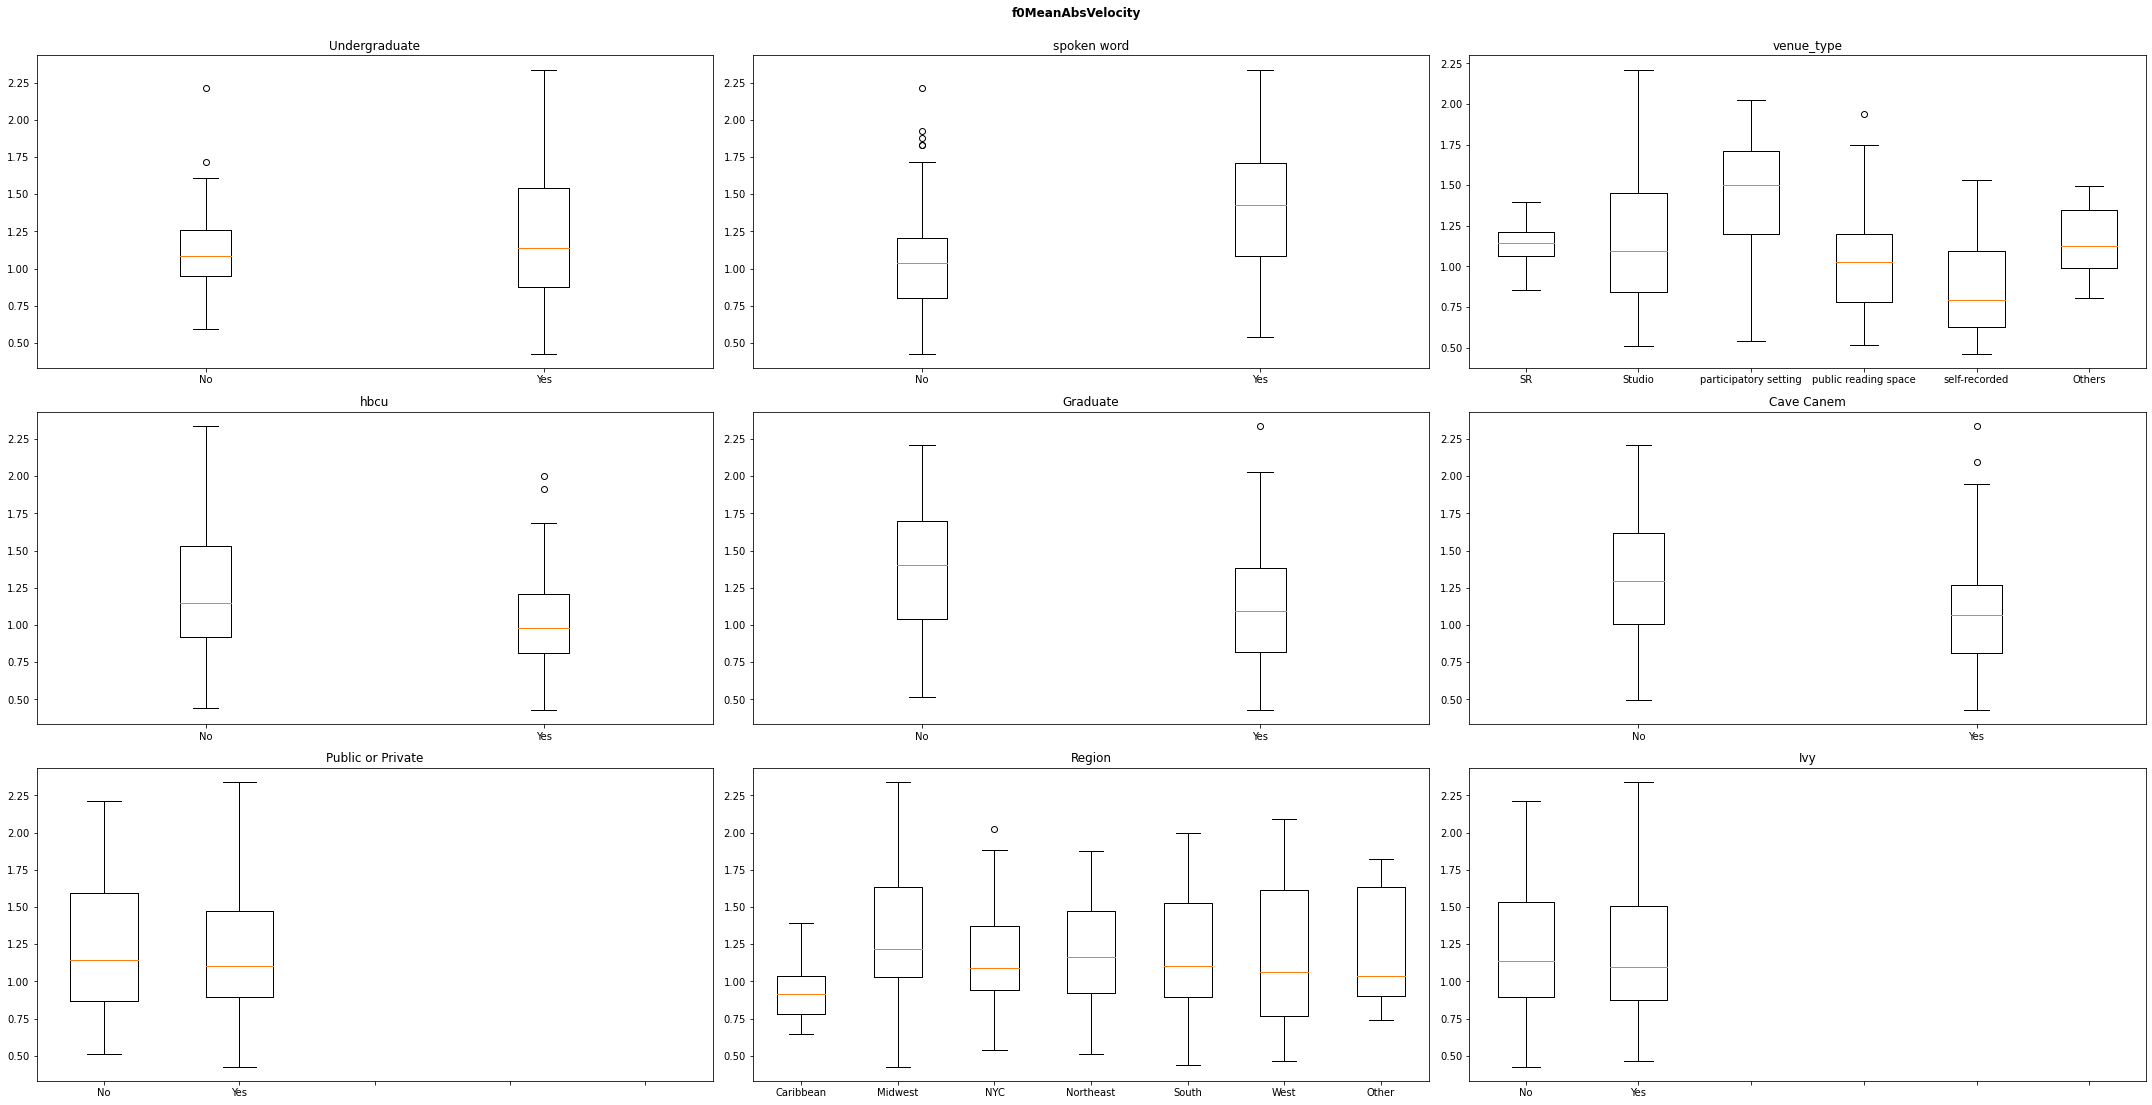

In [8]:
_ = boxplot(measure_name_vet=["f0MeanAbsVelocity"], data_frame=data, figsize=(30,15))

## Box plots of "Dynamism"

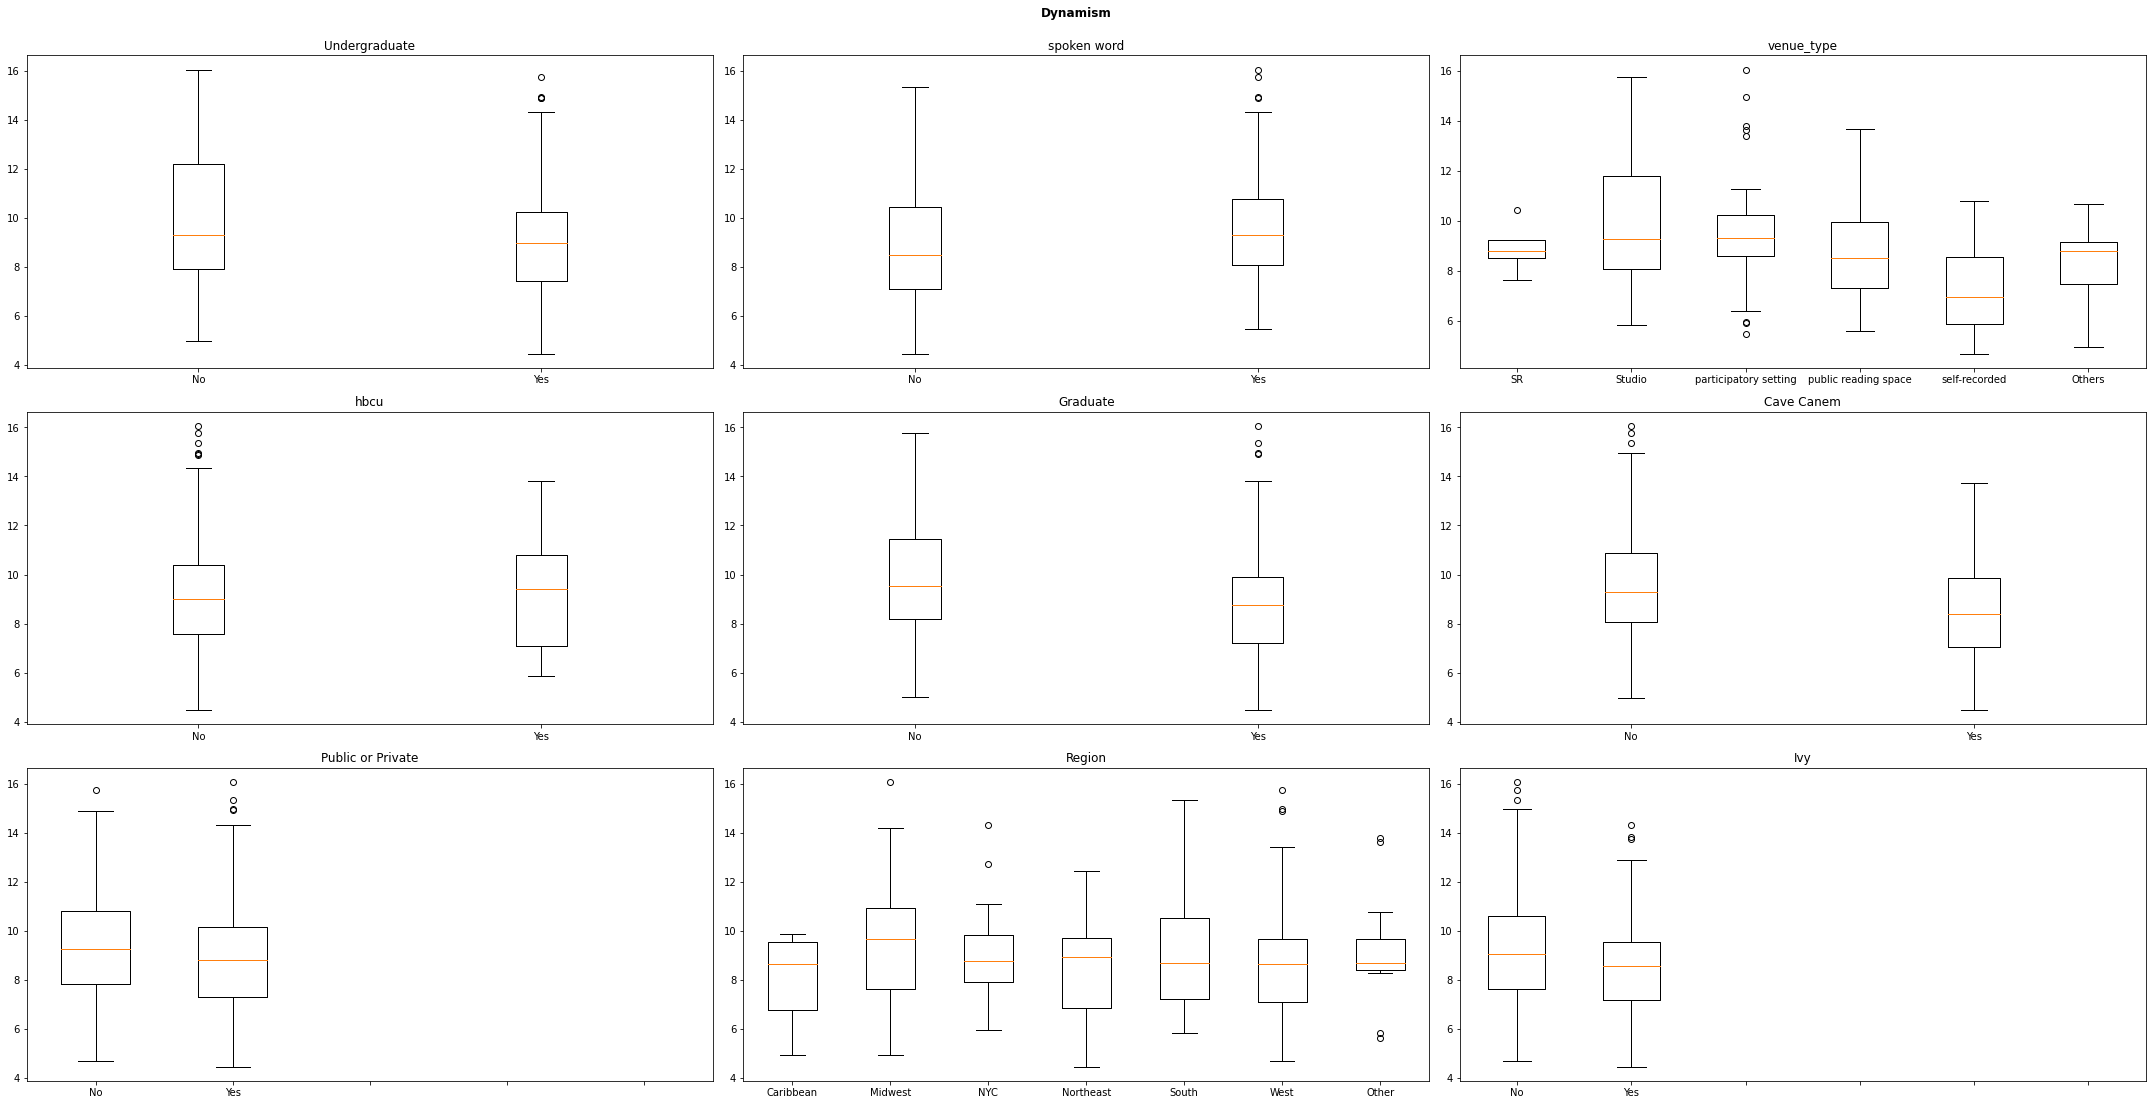

In [9]:
_ = boxplot(measure_name_vet=["Dynamism"], data_frame=data, figsize=(30,15))

## Box plots of "MeanPauseDuration"

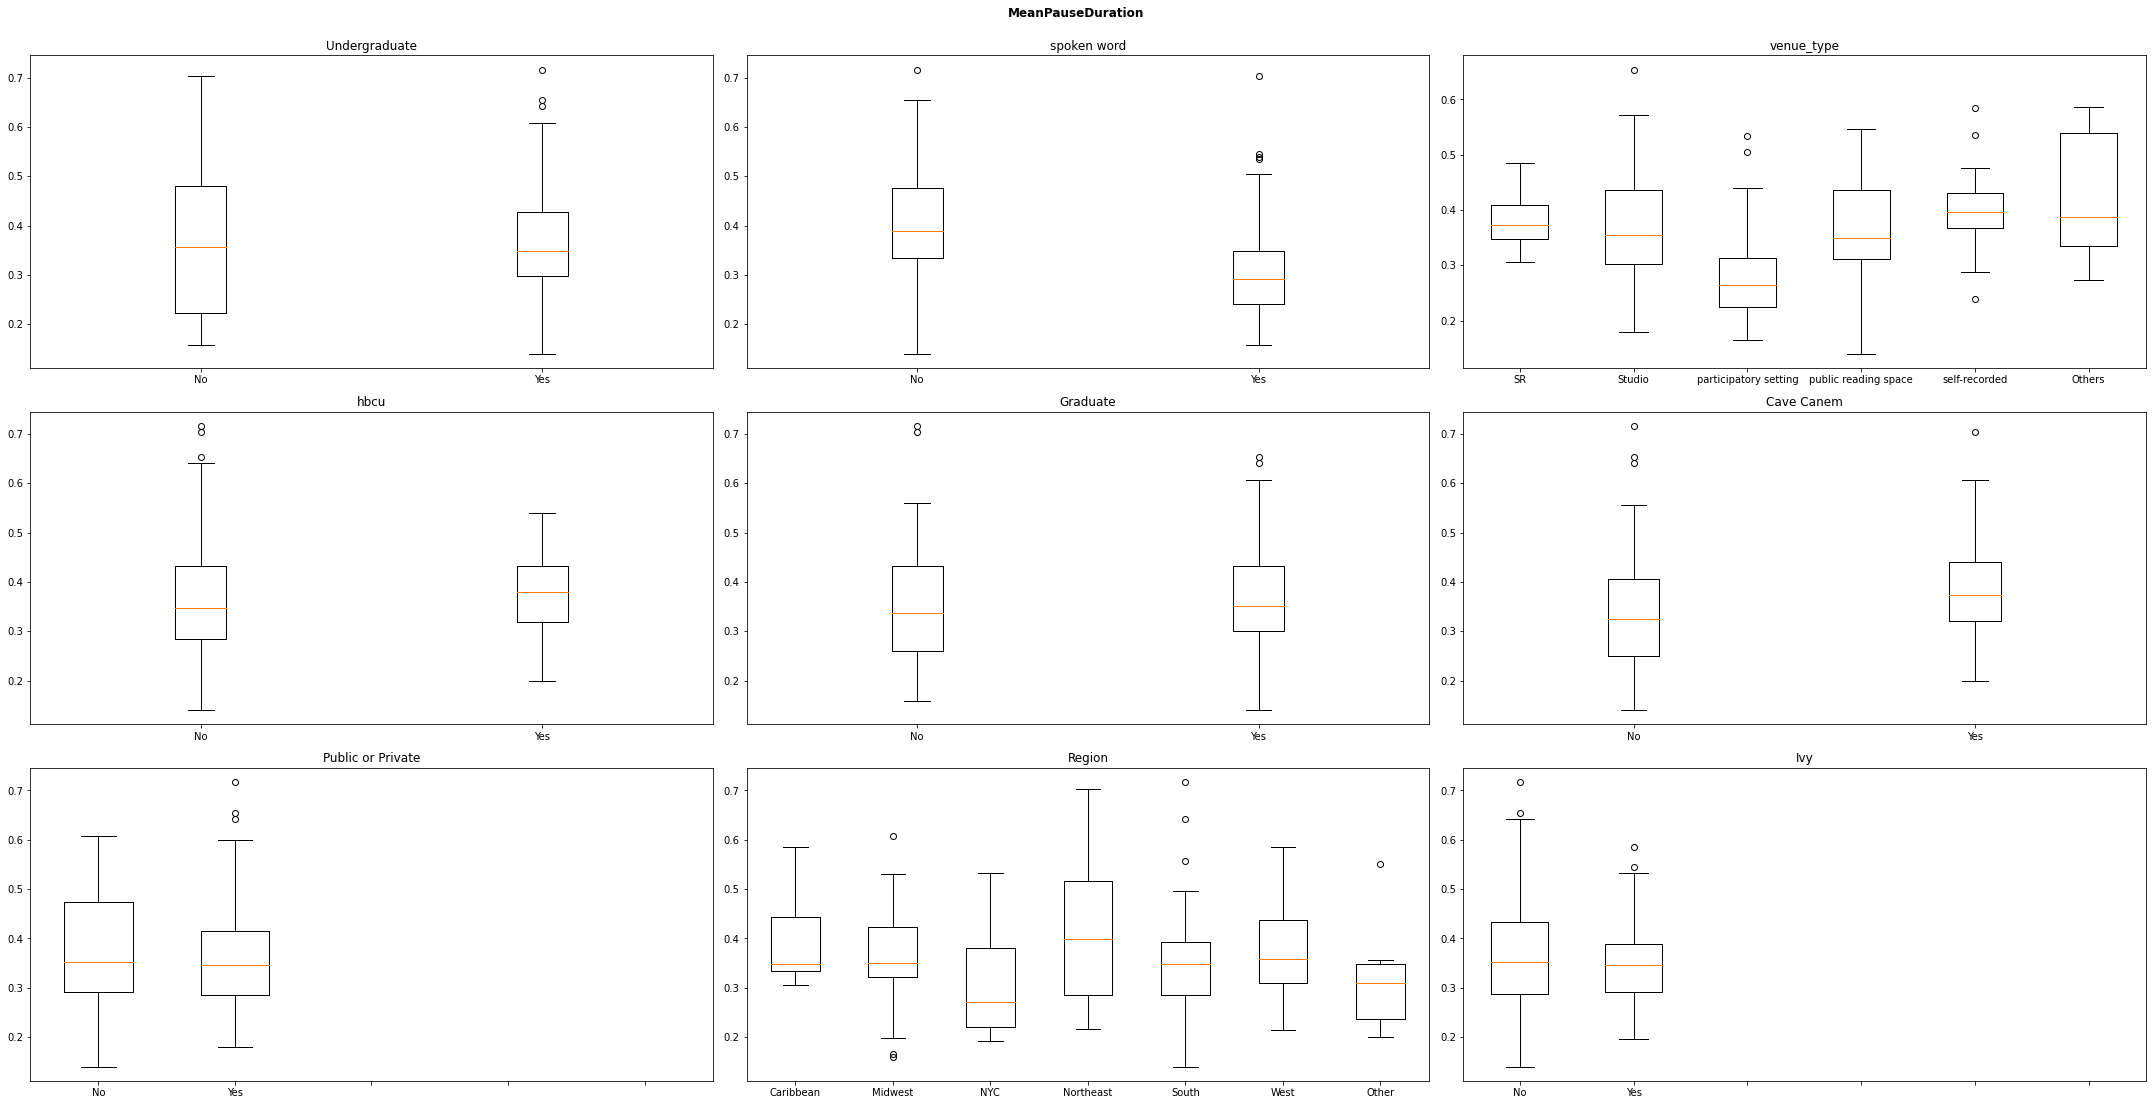

In [10]:
_ = boxplot(measure_name_vet=["MeanPauseDuration"], data_frame=data, figsize=(30,15))

## Box plots of "IntensityMeanAbsVelocity"

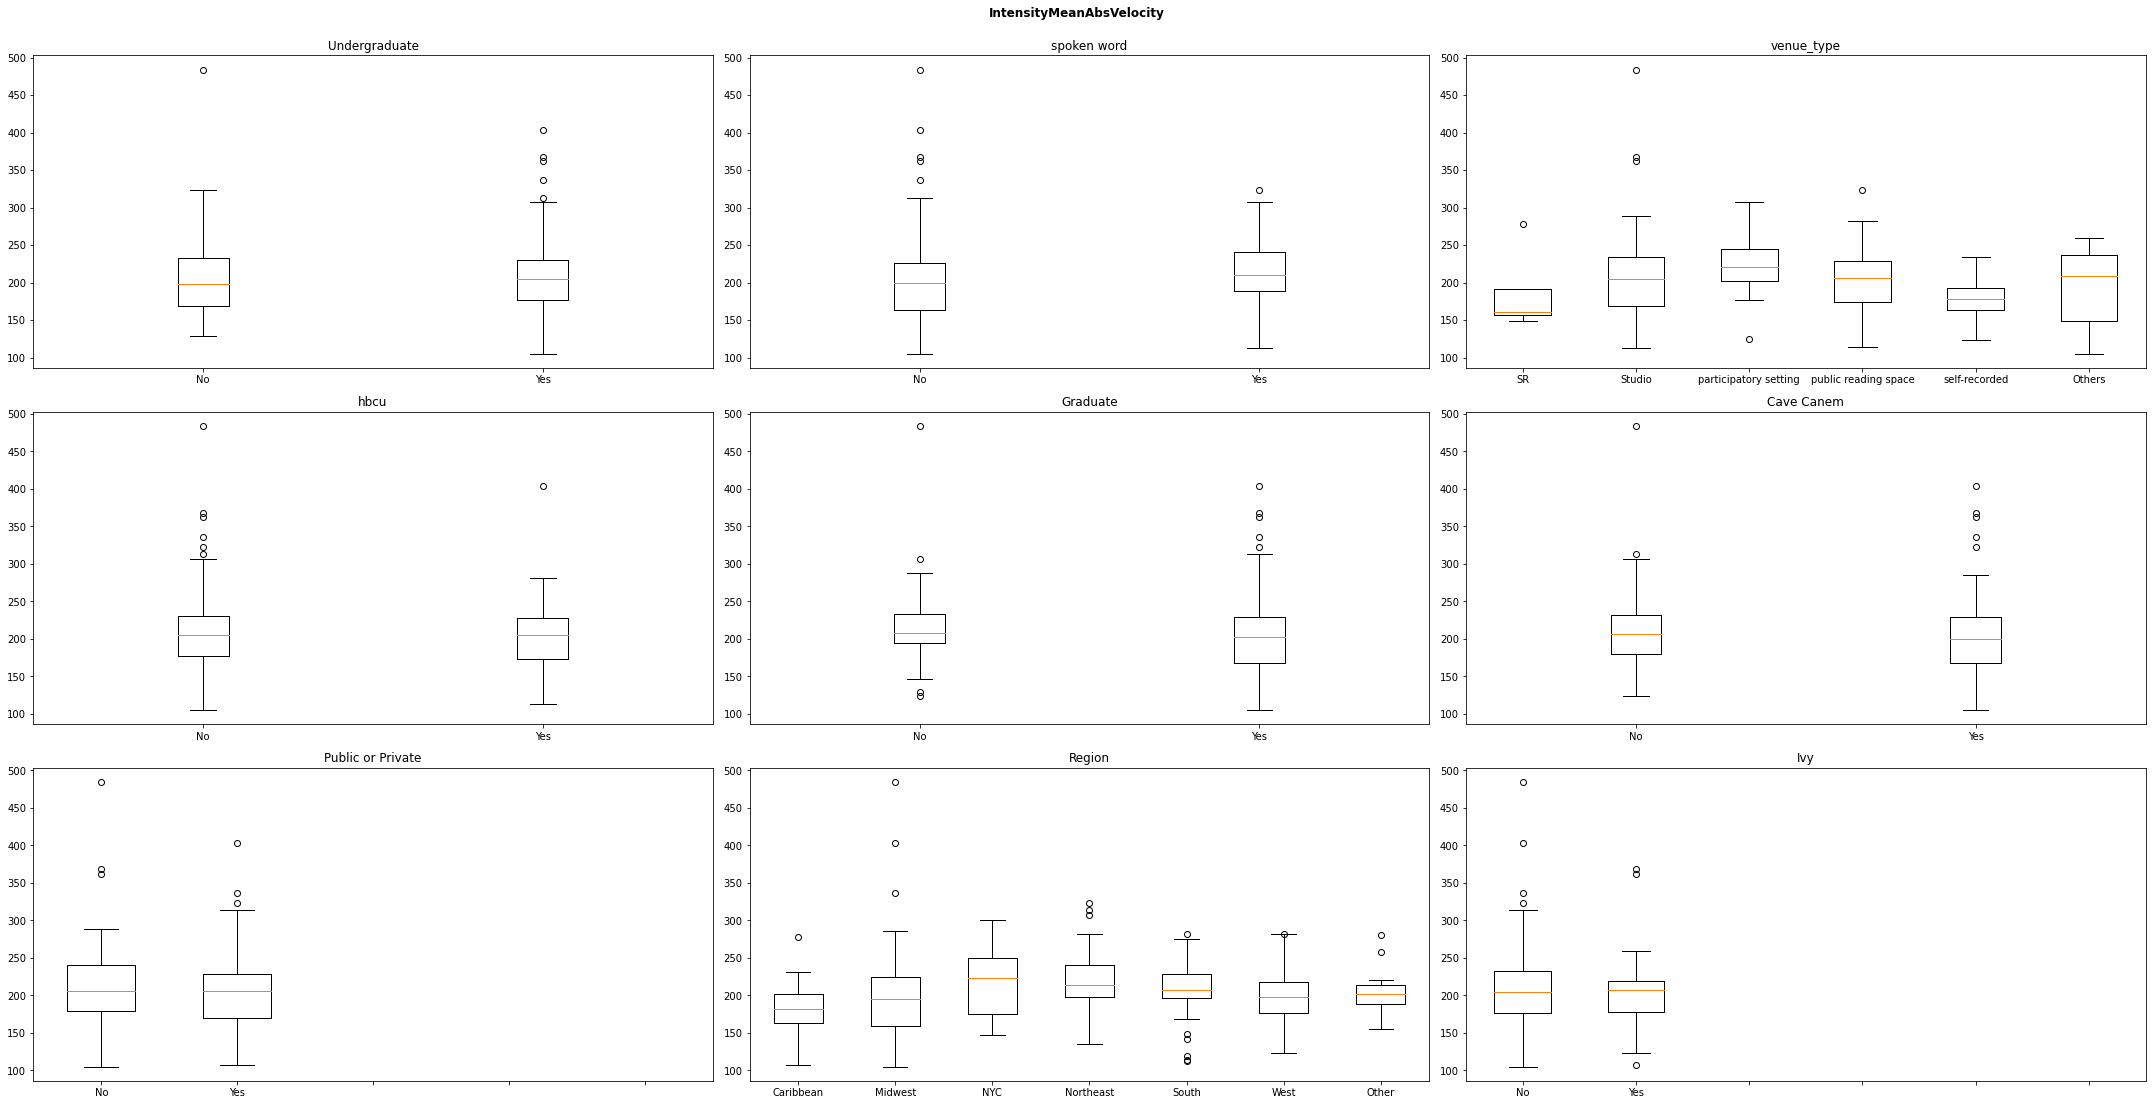

In [11]:
_ = boxplot(measure_name_vet=['IntensityMeanAbsVelocity'], data_frame=data, figsize=(30,15))

# In the following, we fit a linear fixed model to the data

In [12]:
# make author names in the format (last_name first_name)
data['poet_full_name'] = data['author_last_name'] + ' ' + data['author_first_name']

In [13]:
data[["hbcu"]] = data[["hbcu"]].replace({0: False, 1: True})
data[['hbcu']] = data[['hbcu']].fillna(False)
data[['venue_type']] = data[['venue_type']].fillna('Others')
data[["venue_type"]] = data[["venue_type"]].replace({'Slam': 'Others'})

In [14]:
# data = data.rename(columns={
#     'dynamism_original_formula': "Dynamism", 
#     'private_school': "public_private_indicator", 
#     'undergraduate_school': 'undergrad_study_indicator', 
#     'graduate_school': 'graduate_study_indicator', 
#     'ivy': 'Ivy', 
#     'cave_canem': 'cave_canem_indicator',
# })

## In the output, you can look at the "Coef." and "P>|z|" columns. There are several points here.
- When the coef. is neg, it means that increases the value of the variable, f0mean will decrease. 
- If coef is positive, then f0mean increases with increasing values of the variable. 
- "P>|z|" column is the p-value that shows how significant this variable is. 
- Usually, p-value has to be less than 0.05 in order to say this variable is significant, but since we have done multiple testing here, the threshold should be much less than 0.05 or 0.1. 
- For example, if we are doing $n$ tests, then the threshold for p-value should be set as $\frac{0.05}{n}$ or $\frac{0.1}{n}$. That means, only when the corresponding p-value is less than $\frac{0.05}{n}$ or $\frac{0.1}{n}$, we can say that this variable is significant to f0mean. And the same applies to the analysis for intensity, dynamism, etc.
- Taken the multiple testing issue into consideration, outputs with significant results are highlighted with blue color. I have also highlighted the result that has p-value as 0.0x (but less than 0.05) with yellow color, but rigorously, those are not signifcant results due to multiple testing.

## Linear mixed model results for "f0mean"

### Some findings for f0mean (you can also relate these results to the boxplots)
- Spoken word has positive effect on f0mean with a p-value equal to 0.004. This means if the poet belongs to the spoken word category, the f0mean of this poet should be higher.
- If the venue type is participatory setting, f0mean should be significantly higher.

In [36]:
p_value_dict = {}

In [37]:
# f0mean
model_f0m = smf.mixedlm("f0Mean ~ birth_year + C(spoken_word) + C(hbcu) + C(venue_type) + C(cave_canem_indicator) + C(graduate_study_indicator) + C(undergrad_study_indicator) + "
                        "C(region, Treatment('Caribbean'))", data, groups=data['poet_full_name'])
f0m = model_f0m.fit()
p_value_dict["f0Mean"] = f0m.pvalues[1:-1]
print(f0m.summary())

                             Mixed Linear Model Regression Results
Model:                          MixedLM              Dependent Variable:              f0Mean   
No. Observations:               201                  Method:                          REML     
No. Groups:                     101                  Scale:                           597.3431 
Min. group size:                1                    Log-Likelihood:                  -916.7524
Max. group size:                3                    Converged:                       Yes      
Mean group size:                2.0                                                            
-----------------------------------------------------------------------------------------------
                                                Coef.   Std.Err.   z    P>|z|   [0.025   0.975]
-----------------------------------------------------------------------------------------------
Intercept                                      -353.036  343.230 -1.0

### Some findings for IntensityMeanAbsVelocity (you can also relate these results to the boxplots)
- If the venue type is participatory setting, IntensityMeanAbsVelocity should be significantly higher.
- Poets from Caribbean region have significantly higher IntensityMeanAbsVelocit than poets from South and West regions.

## Linear mixed model results for "IntensityMeanAbsVelocity"

In [38]:
# intensity
model_intense = smf.mixedlm("IntensityMeanAbsVelocity ~ birth_year + C(spoken_word) + C(hbcu) + C(venue_type) + C(cave_canem_indicator) + C(graduate_study_indicator) + C(undergrad_study_indicator) + "
                        "C(region, Treatment('Caribbean'))", data, groups=data['poet_full_name'])
intense = model_intense.fit()
p_value_dict["imav"] = intense.pvalues[1:-1]
print(intense.summary())

                            Mixed Linear Model Regression Results
Model:                     MixedLM        Dependent Variable:        IntensityMeanAbsVelocity
No. Observations:          201            Method:                    REML                    
No. Groups:                101            Scale:                     2247.2117               
Min. group size:           1              Log-Likelihood:            -1005.5286              
Max. group size:           3              Converged:                 Yes                     
Mean group size:           2.0                                                               
---------------------------------------------------------------------------------------------
                                                Coef.  Std.Err.   z    P>|z|  [0.025   0.975]
---------------------------------------------------------------------------------------------
Intercept                                       12.717  471.955  0.027 0.979 -912.298 93

## Linear mixed model results for "f0MeanAbsVelocity"

### Some findings for f0MeanAbsVelocity (you can also relate these results to the boxplots)
- Spoken word has significantly higher effect on f0MeanAbsVelocity.
- Birth year has negative impact on f0MeanAbsVelocity. That means, if the birth year is bigger (the poet is born more recently), then f0MeanAbsVelocity is lower.

In [39]:
# f0mean abs velocity
# f0mean abs velocity: cave, graduate, carribean
model_f0mv = smf.mixedlm("f0MeanAbsVelocity ~ birth_year + C(spoken_word) + C(hbcu) + C(venue_type) + C(cave_canem_indicator) + C(graduate_study_indicator) + "
                        "C(region, Treatment('Caribbean'))", data, groups=data['poet_full_name'])
f0mv = model_f0mv.fit()
p_value_dict["f0mv"] = f0mv.pvalues[1:-1]
print(f0mv.summary())

                          Mixed Linear Model Regression Results
Model:                      MixedLM         Dependent Variable:         f0MeanAbsVelocity
No. Observations:           201             Method:                     REML             
No. Groups:                 101             Scale:                      0.0814           
Min. group size:            1               Log-Likelihood:             -90.7895         
Max. group size:            3               Converged:                  Yes              
Mean group size:            2.0                                                          
-----------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      12.210    3.245  3.763 0.000  5.850 18.570
C(spoken_word)[T.True]              

## Linear mixed model results for "Dynamism"

### Some findings for dynamism (you can also relate these results to the boxplots)
- Birth year has negative impact on dynamism. That means, if the birth year is bigger (the poet is born more recently), then dynamism is lower.

In [40]:
# dynamism
# dyn: cave, graduate
model_dyn = smf.mixedlm("Dynamism ~ birth_year + C(cave_canem_indicator) + C(spoken_word) + C(hbcu) + C(venue_type) + C(graduate_study_indicator) + C(undergrad_study_indicator) + "
                        "C(region, Treatment('Caribbean'))", data, groups=data['poet_full_name'])
dyn = model_dyn.fit()
p_value_dict["dyn"] = dyn.pvalues[1:-1]
print(dyn.summary())

                          Mixed Linear Model Regression Results
Model:                         MixedLM            Dependent Variable:            Dynamism 
No. Observations:              201                Method:                        REML     
No. Groups:                    101                Scale:                         3.4992   
Min. group size:               1                  Log-Likelihood:                -428.5012
Max. group size:               3                  Converged:                     Yes      
Mean group size:               2.0                                                        
------------------------------------------------------------------------------------------
                                               Coef.  Std.Err.   z    P>|z| [0.025  0.975]
------------------------------------------------------------------------------------------
Intercept                                      89.217   20.380  4.378 0.000 49.273 129.161
C(cave_canem_indicator)[T.

## Linear mixed model results for "MeanPauseDuration"

### Some findings for MeanPauseDuration (you can also relate these results to the boxplots)
- Spoken word has negative impact on mean pause duration.
- If the venue type is participatory settin, then mean pause duration is lower.
- Birth year has negative impact on dynamism. That means, if the birth year is bigger (the poet is born more recently), then dynamism is lower.

In [41]:
# mean pause duration
# mpr: cave, nyc & northeast
model_pause_duration = smf.mixedlm("MeanPauseDuration ~ birth_year + C(spoken_word) + C(hbcu) + C(venue_type) + C(cave_canem_indicator) + C(graduate_study_indicator) + C(undergrad_study_indicator) + "
                              "C(region, Treatment('NYC'))", data, groups=data['poet_full_name'])
pause_duration = model_pause_duration.fit()
p_value_dict["pause_duration"] = pause_duration.pvalues[1:-1]
print(pause_duration.summary())

                       Mixed Linear Model Regression Results
Model:                    MixedLM       Dependent Variable:       MeanPauseDuration
No. Observations:         201           Method:                   REML             
No. Groups:               101           Scale:                    0.0068           
Min. group size:          1             Log-Likelihood:           136.7231         
Max. group size:          3             Converged:                Yes              
Mean group size:          2.0                                                      
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                 0.986    0.897  1.099 0.272 -0.772  2.744
C(spoken_word)[T.True]                   -0.072    0.021 -3.429 0.001 -0.112 -0.031
C(hbcu)[T.True]

In [21]:
# for res_name, p_value_series in p_value_dict.items():
#     p_value_series.index = res_name + "_" + p_value_series.index

In [42]:
p_value_series = pd.concat(p_value_dict)

In [49]:
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
reject_boolean, _, _, _ = smt.multipletests(p_value_series, method="fdr_bh")

# Benjemini-Hochberg Process

In [51]:
p_value_series[reject_boolean]

f0Mean          C(venue_type)[T.participatory setting]    6.217154e-08
f0mv            C(spoken_word)[T.True]                    2.386409e-05
                birth_year                                6.370637e-04
dyn             birth_year                                8.537606e-05
pause_duration  C(spoken_word)[T.True]                    6.064179e-04
                C(venue_type)[T.participatory setting]    2.463304e-03
dtype: float64